
# Audio classificiation



In [78]:
%matplotlib inline

import torch

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchaudio.transforms as transforms

from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Import data util functions from 'src/'
from src.audio_folder_dataset import AudioFolder
from src.audio_folder_collate_fn import collate_audio_folder_batch

### Define hyperparameters


In [90]:
device = 'cpu'
original_sample_rate = 16000 # Sample rate for the speech commands dataset
new_sample_rate = 8000 # Sample rate for the speech commands dataset
val_size = 0.3 # Size of train / validation split
batch_size = 200 # Batch size for training
num_epochs = 50 # Number of epochs for training (this is a large dataset so not many epochs needed)
log_interval = 20 # Log process every n interations
learning_rate = 0.01 # Learning rate for training
weight_decay = 0.0001 # Weight decay for ADAM optimiser

### Define data transform

When working with torchaudio we can only define one transform here. This function downsamples the audio waveform from a sample rate of 16000 to 8000, which is fine for working with human voices and helps us train more efficiently.

Unlike when working with images, the padding and normalising of the data to the same length happens in the function `collate_audio_folder_batch` in `src/audio_folder_collate_fn.py`. As all of our audio files are different lengths, we need to harmonise them when we load in a random mini-batch. 



In [91]:
transform = transforms.Resample(orig_freq=original_sample_rate, new_freq=new_sample_rate)

### Create datasets

Here we create our dataset classes. Because we are using different transforms, we need to make two seperate dataset classes. We will then take a random sub-selection of our data and split our dataset into two. 

When we do the split, by setting `random_state=42`, we are doing this in a deterministic way, such that we will always get the same 'random' split of data into the training and validation sets.

In [92]:
train_path = 'MUSIC/cut2'

dataset = AudioFolder(train_path, transform=transform)
num_classes = len(dataset.classes)

# Get length of dataset and indicies
num_train = len(dataset)
indices = list(range(num_train))

# Get train / val split for data points
train_indices, val_indices = train_test_split(indices, test_size=val_size, random_state=42)

# Override dataset classes to only be samples for each split
train_subset = torch.utils.data.Subset(dataset, train_indices)
val_subset = torch.utils.data.Subset(dataset, val_indices)

# Create data loaders
train_loader = DataLoader(train_subset, batch_size=batch_size, collate_fn=collate_audio_folder_batch, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, collate_fn=collate_audio_folder_batch,  shuffle=False)

### Plot a sample of the data

Data batch shape: torch.Size([200, 1, 20000])
Shape of waveform: torch.Size([20000])
Class of waveform: '00'


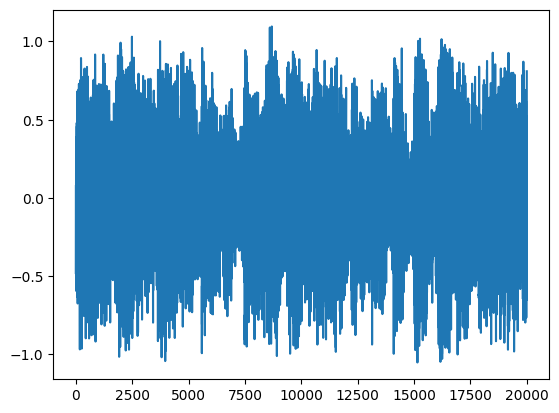

In [93]:
data_batch, label_batch = next(iter(train_loader))
sample_waveform = data_batch[0].squeeze()
print(f'Data batch shape: {data_batch.shape}')
print(f"Shape of waveform: {sample_waveform.size()}")
sample_class = int(label_batch[0].item())
print(f'Class of waveform: \'{dataset.idx_to_class[sample_class]}\'')
plt.plot(sample_waveform.t().numpy())

### Define the Network

Here we define a 1-Dimensional convolutional neural network to process raw audio data. The specific architecture is modeled after the M5 network architecture described in [this paper](https://arxiv.org/pdf/1610.00087.pdf). 

What are the main differences between this and the 2-D convolutional network that we used in Week 3? 




In [94]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return x

### Setup core objects

Here we setup our core objects, the model, the loss function (criterion) and the optimiser.

In [95]:
model = M5(n_input=1, n_output=num_classes)
model.to(device)
print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n = count_parameters(model)
print("Number of parameters: %s" % n)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=4, bias=True)
)
Number

### Evaluation functions

These are functions we can use to get the actual prediction from the model in validation to get an overall accuracy score on the validation set:

In [96]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

### Training loop


Here is our training loop for our data. Look at how the training set and validation set are used differently. 

What differences are there in the code when we cycle through each of these sets of data?

In [102]:
pbar_update = 1 / (len(train_loader) + len(val_loader))

train_losses = []
val_losses = []

best_loss = 100000

# Show progress bar 
with tqdm(total=num_epochs) as pbar:
    
    # For each cycle of the dataset
    for epoch in range(num_epochs):
        # Variables to keep track of running loss
        train_loss = 0.0
        val_loss = 0.0
        
        # Put model in training model
        model.train()
        model.to(device)
        
        # Train loop
        # For each batch in one cycle of the training set
        for batch_idx, (data, target) in enumerate(train_loader):
            pass
            # Move data to whatever device we are running training on
            data = data.to(device)
            target = target.to(device)
            
            # Forward pass with the model
            output = model(data)

            # Evaluate classification accuracy
            loss = criterion(output.squeeze(), target)
            
            # Backpropagate loss and update gradients
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Keep track off loss over time
            train_loss += loss.item()

            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

            # update progress bar
            pbar.update(pbar_update)

        # Put model in evaluation mode (turn off batch norm)
        model.eval()
        model.to(device)
        # Without gradient tracking 
        with torch.no_grad():
            
            # Variable to track total correct classifications
            correct = 0

            # Validation loop
            # For each batch in one cycle of the validation set
            for data, target in val_loader:
                
                # Move data to whatever device we are running training on
                data = data.to(device)
                target = target.to(device)

                # Forward pass with the model
                output = model(data)

                # Evaluate classification accuracy
                loss = criterion(output.squeeze(), target)
                
                # Track loss
                val_loss += loss.item()

                # Get top prediction
                pred = get_likely_index(output)
                
                # Check if prediction is correct
                correct += number_of_correct(pred, target)

                # update progress bar
                pbar.update(pbar_update)
        
        # Normalise cumulative losses to dataset size
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        
        # Added cumulative losses to lists for later display
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(val_loader.dataset)} ({100. * correct / len(val_loader.dataset):.0f}%)\n")

        # if validation score is lowest so far, save the model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.cpu().state_dict(), 'best_audio_classifier.pt')



  0%|          | 0.1111111111111111/50 [00:02<16:37, 19.99s/it]

Train Epoch: 0 [0/1043 (0%)]	Loss: 0.256403


  2%|▏         | 1.0000000000000002/50 [00:17<11:06, 13.61s/it]


Test Epoch: 0	Accuracy: 190/447 (43%)



  2%|▏         | 1.1111111111111114/50 [00:19<12:37, 15.50s/it]

Train Epoch: 1 [0/1043 (0%)]	Loss: 0.174713


  4%|▍         | 2.0000000000000004/50 [00:36<12:50, 16.05s/it]


Test Epoch: 1	Accuracy: 198/447 (44%)



  4%|▍         | 2.1111111111111116/50 [00:39<14:01, 17.57s/it]

Train Epoch: 2 [0/1043 (0%)]	Loss: 0.225281


  6%|▌         | 3.000000000000001/50 [00:55<11:23, 14.54s/it] 


Test Epoch: 2	Accuracy: 201/447 (45%)



  6%|▌         | 3.111111111111112/50 [00:57<13:22, 17.11s/it]

Train Epoch: 3 [0/1043 (0%)]	Loss: 0.165735


  8%|▊         | 4.000000000000001/50 [01:13<10:44, 14.01s/it] 


Test Epoch: 3	Accuracy: 206/447 (46%)



  8%|▊         | 4.111111111111112/50 [01:16<11:59, 15.68s/it]

Train Epoch: 4 [0/1043 (0%)]	Loss: 0.195898


 10%|▉         | 4.999999999999997/50 [01:31<11:04, 14.76s/it] 


Test Epoch: 4	Accuracy: 179/447 (40%)



 10%|█         | 5.111111111111108/50 [01:33<12:38, 16.90s/it]

Train Epoch: 5 [0/1043 (0%)]	Loss: 0.138747


 12%|█▏        | 5.999999999999994/50 [01:50<11:12, 15.27s/it] 


Test Epoch: 5	Accuracy: 198/447 (44%)



 12%|█▏        | 6.1111111111111045/50 [01:53<13:47, 18.85s/it]

Train Epoch: 6 [0/1043 (0%)]	Loss: 0.125583


 14%|█▍        | 6.99999999999999/50 [02:10<11:09, 15.56s/it]  


Test Epoch: 6	Accuracy: 189/447 (42%)



 14%|█▍        | 7.111111111111101/50 [02:13<15:18, 21.41s/it]

Train Epoch: 7 [0/1043 (0%)]	Loss: 0.133708


 16%|█▌        | 7.999999999999987/50 [02:31<10:46, 15.38s/it] 


Test Epoch: 7	Accuracy: 212/447 (47%)



 16%|█▌        | 8.111111111111098/50 [02:33<11:40, 16.72s/it]

Train Epoch: 8 [0/1043 (0%)]	Loss: 0.158236


 18%|█▊        | 8.999999999999984/50 [02:48<08:57, 13.11s/it]


Test Epoch: 8	Accuracy: 177/447 (40%)



 18%|█▊        | 9.111111111111095/50 [02:50<10:26, 15.31s/it]

Train Epoch: 9 [0/1043 (0%)]	Loss: 0.104713


 20%|█▉        | 9.99999999999998/50 [03:04<08:40, 13.01s/it] 


Test Epoch: 9	Accuracy: 195/447 (44%)



 20%|██        | 10.111111111111091/50 [03:07<10:24, 15.65s/it]

Train Epoch: 10 [0/1043 (0%)]	Loss: 0.150124


 22%|██▏       | 10.999999999999977/50 [03:21<08:12, 12.63s/it]


Test Epoch: 10	Accuracy: 131/447 (29%)



 22%|██▏       | 11.111111111111088/50 [03:23<09:32, 14.73s/it]

Train Epoch: 11 [0/1043 (0%)]	Loss: 0.097658


 24%|██▍       | 11.999999999999973/50 [03:37<08:18, 13.13s/it]


Test Epoch: 11	Accuracy: 242/447 (54%)



 24%|██▍       | 12.111111111111084/50 [03:39<09:47, 15.52s/it]

Train Epoch: 12 [0/1043 (0%)]	Loss: 0.102508


 26%|██▌       | 12.99999999999997/50 [03:53<07:47, 12.64s/it] 


Test Epoch: 12	Accuracy: 167/447 (37%)



 26%|██▌       | 13.11111111111108/50 [03:56<09:50, 16.02s/it]

Train Epoch: 13 [0/1043 (0%)]	Loss: 0.119000


 28%|██▊       | 13.999999999999966/50 [04:11<08:05, 13.48s/it]


Test Epoch: 13	Accuracy: 233/447 (52%)



 28%|██▊       | 14.111111111111077/50 [04:13<09:19, 15.59s/it]

Train Epoch: 14 [0/1043 (0%)]	Loss: 0.056874


 30%|██▉       | 14.999999999999963/50 [04:27<07:32, 12.93s/it]


Test Epoch: 14	Accuracy: 217/447 (49%)



 30%|███       | 15.111111111111073/50 [04:30<08:29, 14.59s/it]

Train Epoch: 15 [0/1043 (0%)]	Loss: 0.091728


 32%|███▏      | 15.99999999999996/50 [04:44<07:27, 13.17s/it] 


Test Epoch: 15	Accuracy: 229/447 (51%)



 32%|███▏      | 16.11111111111107/50 [04:46<08:27, 14.97s/it]

Train Epoch: 16 [0/1043 (0%)]	Loss: 0.094110


 34%|███▍      | 16.999999999999957/50 [05:01<07:48, 14.18s/it]


Test Epoch: 16	Accuracy: 212/447 (47%)



 34%|███▍      | 17.111111111111068/50 [05:03<09:17, 16.96s/it]

Train Epoch: 17 [0/1043 (0%)]	Loss: 0.064431


 36%|███▌      | 17.999999999999954/50 [05:22<08:19, 15.61s/it]


Test Epoch: 17	Accuracy: 225/447 (50%)



 36%|███▌      | 18.111111111111065/50 [05:25<09:17, 17.47s/it]

Train Epoch: 18 [0/1043 (0%)]	Loss: 0.108908


 38%|███▊      | 18.99999999999995/50 [05:40<07:31, 14.57s/it] 


Test Epoch: 18	Accuracy: 222/447 (50%)



 38%|███▊      | 19.11111111111106/50 [05:43<09:14, 17.96s/it]

Train Epoch: 19 [0/1043 (0%)]	Loss: 0.096969


 40%|███▉      | 19.999999999999947/50 [05:59<06:54, 13.80s/it]


Test Epoch: 19	Accuracy: 227/447 (51%)



 40%|████      | 20.111111111111057/50 [06:01<07:41, 15.45s/it]

Train Epoch: 20 [0/1043 (0%)]	Loss: 0.052067


 42%|████▏     | 20.999999999999943/50 [06:17<06:43, 13.92s/it]


Test Epoch: 20	Accuracy: 177/447 (40%)



 42%|████▏     | 21.111111111111054/50 [06:19<07:39, 15.89s/it]

Train Epoch: 21 [0/1043 (0%)]	Loss: 0.072465


 44%|████▍     | 21.99999999999994/50 [06:34<06:26, 13.81s/it] 


Test Epoch: 21	Accuracy: 218/447 (49%)



 44%|████▍     | 22.11111111111105/50 [06:37<08:20, 17.95s/it]

Train Epoch: 22 [0/1043 (0%)]	Loss: 0.060267


 46%|████▌     | 22.999999999999936/50 [06:52<06:12, 13.80s/it]


Test Epoch: 22	Accuracy: 210/447 (47%)



 46%|████▌     | 23.111111111111047/50 [06:54<06:54, 15.42s/it]

Train Epoch: 23 [0/1043 (0%)]	Loss: 0.074408


 48%|████▊     | 23.999999999999932/50 [07:10<06:13, 14.37s/it]


Test Epoch: 23	Accuracy: 231/447 (52%)



 48%|████▊     | 24.111111111111043/50 [07:12<07:07, 16.51s/it]

Train Epoch: 24 [0/1043 (0%)]	Loss: 0.083690


 50%|████▉     | 24.99999999999993/50 [07:27<05:37, 13.50s/it] 


Test Epoch: 24	Accuracy: 167/447 (37%)



 50%|█████     | 25.11111111111104/50 [07:29<06:13, 15.00s/it]

Train Epoch: 25 [0/1043 (0%)]	Loss: 0.145830


 52%|█████▏    | 25.999999999999925/50 [07:44<05:31, 13.81s/it]


Test Epoch: 25	Accuracy: 180/447 (40%)



 52%|█████▏    | 26.111111111111036/50 [07:46<06:21, 15.96s/it]

Train Epoch: 26 [0/1043 (0%)]	Loss: 0.126778


 54%|█████▍    | 26.999999999999922/50 [08:00<04:56, 12.91s/it]


Test Epoch: 26	Accuracy: 217/447 (49%)



 54%|█████▍    | 27.111111111111033/50 [08:02<05:35, 14.67s/it]

Train Epoch: 27 [0/1043 (0%)]	Loss: 0.091570


 56%|█████▌    | 27.99999999999992/50 [08:17<04:59, 13.60s/it] 


Test Epoch: 27	Accuracy: 198/447 (44%)



 56%|█████▌    | 28.11111111111103/50 [08:20<05:35, 15.31s/it]

Train Epoch: 28 [0/1043 (0%)]	Loss: 0.122179


 58%|█████▊    | 28.999999999999915/50 [08:34<04:30, 12.90s/it]


Test Epoch: 28	Accuracy: 240/447 (54%)



 58%|█████▊    | 29.111111111111025/50 [08:36<05:07, 14.73s/it]

Train Epoch: 29 [0/1043 (0%)]	Loss: 0.069612


 60%|█████▉    | 29.99999999999991/50 [08:53<05:29, 16.48s/it] 


Test Epoch: 29	Accuracy: 230/447 (51%)



 60%|██████    | 30.111111111111022/50 [08:56<06:37, 19.97s/it]

Train Epoch: 30 [0/1043 (0%)]	Loss: 0.092233


 62%|██████▏   | 30.999999999999908/50 [09:12<04:32, 14.34s/it]


Test Epoch: 30	Accuracy: 203/447 (45%)



 62%|██████▏   | 31.11111111111102/50 [09:14<05:16, 16.74s/it] 

Train Epoch: 31 [0/1043 (0%)]	Loss: 0.080426


 64%|██████▍   | 31.999999999999904/50 [09:28<03:53, 12.98s/it]


Test Epoch: 31	Accuracy: 220/447 (49%)



 64%|██████▍   | 32.111111111111015/50 [09:31<04:23, 14.74s/it]

Train Epoch: 32 [0/1043 (0%)]	Loss: 0.057800


 66%|██████▌   | 32.99999999999993/50 [09:46<03:55, 13.85s/it] 


Test Epoch: 32	Accuracy: 225/447 (50%)



 66%|██████▌   | 33.11111111111104/50 [09:48<04:26, 15.80s/it]

Train Epoch: 33 [0/1043 (0%)]	Loss: 0.035358


 68%|██████▊   | 33.99999999999996/50 [10:02<03:23, 12.71s/it] 


Test Epoch: 33	Accuracy: 231/447 (52%)



 68%|██████▊   | 34.11111111111107/50 [10:04<03:52, 14.66s/it]

Train Epoch: 34 [0/1043 (0%)]	Loss: 0.074972


 70%|██████▉   | 34.999999999999986/50 [10:19<03:25, 13.72s/it]


Test Epoch: 34	Accuracy: 177/447 (40%)



 70%|███████   | 35.1111111111111/50 [10:21<03:50, 15.45s/it]  

Train Epoch: 35 [0/1043 (0%)]	Loss: 0.050992


 72%|███████▏  | 36.000000000000014/50 [10:37<03:27, 14.85s/it]


Test Epoch: 35	Accuracy: 215/447 (48%)



 72%|███████▏  | 36.11111111111113/50 [10:40<04:14, 18.34s/it] 

Train Epoch: 36 [0/1043 (0%)]	Loss: 0.096698


 74%|███████▍  | 37.00000000000004/50 [10:57<03:15, 15.01s/it] 


Test Epoch: 36	Accuracy: 212/447 (47%)



 74%|███████▍  | 37.11111111111116/50 [11:00<03:40, 17.09s/it]

Train Epoch: 37 [0/1043 (0%)]	Loss: 0.058448


 76%|███████▌  | 38.00000000000007/50 [11:18<03:23, 16.95s/it] 


Test Epoch: 37	Accuracy: 199/447 (45%)



 76%|███████▌  | 38.111111111111185/50 [11:20<03:41, 18.65s/it]

Train Epoch: 38 [0/1043 (0%)]	Loss: 0.074197


 78%|███████▊  | 39.0000000000001/50 [11:36<02:46, 15.18s/it]  


Test Epoch: 38	Accuracy: 228/447 (51%)



 78%|███████▊  | 39.111111111111214/50 [11:39<03:24, 18.79s/it]

Train Epoch: 39 [0/1043 (0%)]	Loss: 0.067884


 80%|████████  | 40.00000000000013/50 [11:58<02:29, 14.93s/it] 


Test Epoch: 39	Accuracy: 202/447 (45%)



 80%|████████  | 40.11111111111124/50 [12:00<02:46, 16.88s/it]

Train Epoch: 40 [0/1043 (0%)]	Loss: 0.016016


 82%|████████▏ | 41.000000000000156/50 [12:17<02:22, 15.87s/it]


Test Epoch: 40	Accuracy: 217/447 (49%)



 82%|████████▏ | 41.11111111111127/50 [12:20<02:48, 18.98s/it] 

Train Epoch: 41 [0/1043 (0%)]	Loss: 0.075153


 84%|████████▍ | 42.000000000000185/50 [12:45<03:08, 23.53s/it]


Test Epoch: 41	Accuracy: 199/447 (45%)



 84%|████████▍ | 42.1111111111113/50 [12:49<03:25, 26.05s/it]  

Train Epoch: 42 [0/1043 (0%)]	Loss: 0.037470


 86%|████████▌ | 43.00000000000021/50 [13:05<01:40, 14.40s/it] 


Test Epoch: 42	Accuracy: 221/447 (49%)



 86%|████████▌ | 43.11111111111133/50 [13:07<01:57, 17.00s/it]

Train Epoch: 43 [0/1043 (0%)]	Loss: 0.067350


 88%|████████▊ | 44.00000000000024/50 [13:23<01:20, 13.42s/it] 


Test Epoch: 43	Accuracy: 214/447 (48%)



 88%|████████▊ | 44.111111111111356/50 [13:25<01:27, 14.79s/it]

Train Epoch: 44 [0/1043 (0%)]	Loss: 0.078011


 90%|█████████ | 45.00000000000027/50 [13:40<01:11, 14.25s/it] 


Test Epoch: 44	Accuracy: 200/447 (45%)



 90%|█████████ | 45.111111111111384/50 [13:42<01:18, 16.09s/it]

Train Epoch: 45 [0/1043 (0%)]	Loss: 0.068228


 92%|█████████▏| 46.0000000000003/50 [14:00<01:02, 15.56s/it]  


Test Epoch: 45	Accuracy: 235/447 (53%)



 92%|█████████▏| 46.11111111111141/50 [14:02<01:10, 18.17s/it]

Train Epoch: 46 [0/1043 (0%)]	Loss: 0.036610


 94%|█████████▍| 47.00000000000033/50 [14:21<00:50, 16.99s/it] 


Test Epoch: 46	Accuracy: 217/447 (49%)



 94%|█████████▍| 47.11111111111144/50 [14:23<00:52, 18.16s/it]

Train Epoch: 47 [0/1043 (0%)]	Loss: 0.155213


 96%|█████████▌| 48.000000000000355/50 [14:39<00:30, 15.01s/it]


Test Epoch: 47	Accuracy: 197/447 (44%)



 96%|█████████▌| 48.11111111111147/50 [14:42<00:34, 18.28s/it] 

Train Epoch: 48 [0/1043 (0%)]	Loss: 0.116496


 98%|█████████▊| 49.000000000000384/50 [14:57<00:13, 13.25s/it]


Test Epoch: 48	Accuracy: 215/447 (48%)



 98%|█████████▊| 49.1111111111115/50 [15:00<00:14, 16.31s/it]  

Train Epoch: 49 [0/1043 (0%)]	Loss: 0.095722


100%|██████████| 50.00000000000041/50 [15:15<00:00, 18.32s/it] 


Test Epoch: 49	Accuracy: 185/447 (41%)



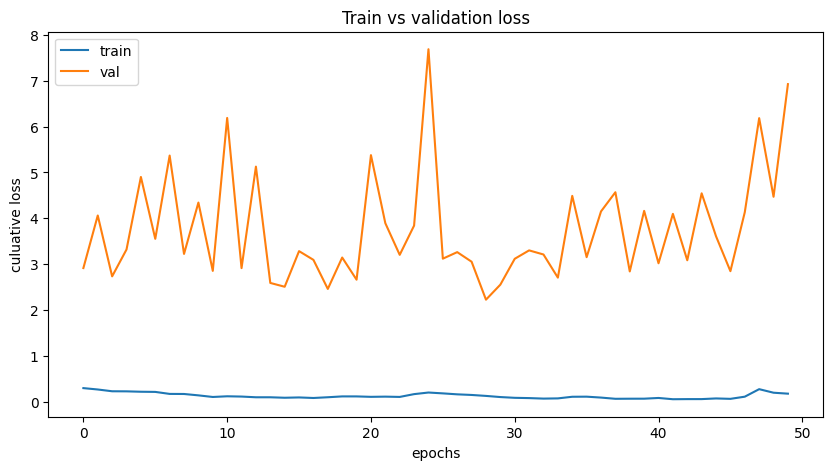

In [103]:
plt.figure(figsize=(10,5))
plt.title("Train vs validation loss")
plt.plot(train_losses,label="train")
plt.plot(val_losses,label="val")
plt.xlabel("epochs")
plt.ylabel("culuative loss")
plt.legend()
plt.show()

## Task

**Task 1:**: Run all the code to train a model. While that is running look at this code and compare it side-by-side with the image classifier training code from Week 3. What are the main differences? What code is unchanged between the two approaches?

**Task 2:** Based on the code in this notebook, create a new dataset class and data loader to load in the test dataset (see `speech-commands/test`) and get a cumulative score for the accuracy, just like what has been done with the validation set. What is the score for the test set?

### Bonus tasks

Here are some bonus tasks if you want to take this work further. You do not need to do these in order:

**Task A:** Can you use this code to train a model on a different audio classificaiton dataset?

**Task B:** Can you take your trained model and build it into an interactive application that responds to voice commands? The words used for training are the names of the folders in the training set.

**Task C:** Can you change [the transform to be calculate an MFCC](https://pytorch.org/audio/main/generated/torchaudio.transforms.MFCC.html) (Mel-Frequence Cepstrum Coefficient) instead of training the network on a raw waveform? There are a couple of ways of doing this:
- **Approach A:** [Change the downsampling transform](https://pytorch.org/audio/main/generated/torchaudio.transforms.MFCC.html) to calculate an MFCC instead. Then in the collate function (`src/audio_folder_collate_fn.py`) you can flatten the 2D MFCC respresentation into a 1-D vector before all the vectors then get padded to the same length. This way you can continue to use the 1-D CNN in this notebook. 
- **Approach B:** Keep the downsampling transform the same. Instead, calculate the MFCC in the collate function after padding has been applied (`src/audio_folder_collate_fn.py`), this way all the MFCCs will have the same dimensionality. Instead of flattening the MFCC matricies into vectors, you can then repace the [1D CNN code](#define-the-network) with a 2-D CNN instead and train a classifier on the MFCC matricies (You can borrow coe from Week 3 for this).




### Task 2 solutions

In [104]:
test_path = 'MUSIC/verify'
dataset = AudioFolder(train_path, transform=transform)
test_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_audio_folder_batch, shuffle=True)

In [106]:
model.to(device)
with torch.no_grad():
    test_loss = 0.0
    test_correct = 0.0
    for data, target in test_loader:
        
        # Move data to whatever device we are running training on
        data = data.to(device)
        target = target.to(device)

        # Forward pass with the model
        output = model(data)

        # Evaluate classification accuracy
        loss = criterion(output.squeeze(), target)
        
        # Track loss
        val_loss += loss.item()

        # Get top prediction
        pred = get_likely_index(output)
        
        # Check if prediction is correct
        test_correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

print(test_correct)

#we got 1495 music slice so we can caculate the accuracy
Accuracy=test_correct/1495*100
print('The accuracy of the model is:',Accuracy,'%')

752.0
The accuracy of the model is: 50.30100334448161 %
